In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import interpolate, stats

from astropy import constants as const
from astropy import units as u

from plotting_spectra import *

rc_params = {
    'lines.linewidth': 2,  # Set line width to 2 points
    'font.family': 'STIXGeneral',  # Set color cycle for axes
    'ytick.direction': 'in',  # Set figure size in inches
    'xtick.direction': 'in',  # Set default font family
}

plt.rcParams.update(rc_params)

In [2]:
spectra_metadata = pd.read_csv('wiserep_spectra_metadata.csv', low_memory=False)
spectra_data     = pd.read_pickle('spectra_ALeRCE20240801_x_wisrep_20240622.pkl')

In [3]:
spectra_data.head(3)

,oid,snname,instrument,mjd,lambda_grid_min,lambda_grid_max,nlambda_grid,lambda_data_min,lambda_data_max,flux_lambda,flux_lambda_smooth,e_flux_lambda
0,NaN,SN2022pru,Lick-3m_KAST,59788.215972,3206.34,10915.01,1838,3504.527001,10393.131809,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.21898910712578754, 0.1979063641775711, 0.18..."
1,NaN,SN2022ytx,LT_SPRAT,59886.979942,3206.34,10915.01,1838,4047.600000,7994.400000,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.2513674591903225, 0.2889965846960843, 0.113..."
2,NaN,SN2022ytx,LT_SPRAT,59907.898866,3206.34,10915.01,1838,4066.000000,7994.400000,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.12373791200226614, 0.10053409443820172, 0.1..."


In [4]:
spectra_data.columns, spectra_data.shape

(Index(['oid', 'snname', 'instrument', 'mjd', 'lambda_grid_min',
        'lambda_grid_max', 'nlambda_grid', 'lambda_data_min', 'lambda_data_max',
        'flux_lambda', 'e_flux_lambda'],
       dtype='object'),
 (25953, 11))

In [5]:
spectra_data.lambda_grid_min

0        3206.34
1        3206.34
2        3206.34
3        3206.34
4        3206.34
          ...   
25948    3206.34
25949    3206.34
25950    3206.34
25951    3206.34
25952    3206.34
Name: lambda_grid_min, Length: 25953, dtype: float64

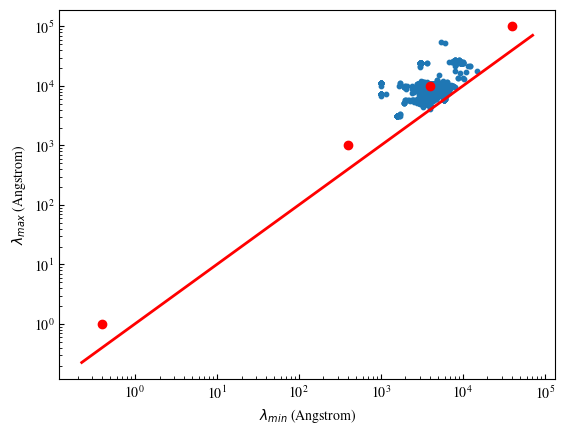

In [6]:
fig,ax =plt.subplots()
ax.scatter(spectra_data.lambda_data_min,spectra_data.lambda_data_max,s=10)

ax.set_yscale('log')
ax.set_xscale('log')
ax.scatter(400/1000, 1000/1000, c='r')
ax.scatter(400, 1000, c='r')
ax.scatter(4000, 10000, c='r')
ax.scatter(40000, 100000, c='r')
ax.plot(ax.get_xlim(),ax.get_xlim(),color='red')
ax.set_xlabel(r'$\lambda_{min}$ (Angstrom)')
ax.set_ylabel(r'$\lambda_{max}$ (Angstrom)')

plt.show()

How we could see there are, at leats,thre points outlayer for the line two with a value less than 10^3 and one over 10^4.

These supernovae are:

In [7]:
spectra_data[(spectra_data.lambda_data_min < 1000)| (spectra_data.lambda_data_min > 30000)][['oid','snname','lambda_data_min','lambda_data_max']]

,oid,snname,lambda_data_min,lambda_data_max


In [8]:
spectra_data[(spectra_data.lambda_data_min < spectra_data.lambda_grid_min)][['oid','snname','lambda_data_min','lambda_data_max']]

,oid,snname,lambda_data_min,lambda_data_max
5,ZTF18aahrzkb,SN2020xqj,3200.560090,9998.678015
11,NaN,PTF10ol,3041.062024,10322.394453
12,NaN,PTF10ol,3041.062024,10322.394453
48,NaN,SN2016fhu,3101.020000,10235.775000
69,NaN,PTF10rex,3080.000000,10050.000000
...,...,...,...,...
25913,ZTF21abwycli,SN2021xyh,3060.381800,10294.838000
25922,NaN,PTF12fip,3200.000000,10500.000000
25934,NaN,PTF10qkv,3080.000000,10100.000000
25935,NaN,PTF10qkv,3150.000000,9500.000000


In [9]:
# spectra_data.loc[4236, 'lambda_data_min'] *= 1e4
# spectra_data.loc[4236, 'lambda_data_max'] *= 1e4
# spectra_data.loc[21198, 'lambda_data_min'] /= 1e1
# spectra_data.loc[21198, 'lambda_data_max'] /= 1e1
# spectra_data.loc[21334, 'lambda_data_min'] *= 1e1
# spectra_data.loc[21334, 'lambda_data_max'] *= 1e1

In [10]:
spectra_data[(spectra_data.lambda_data_min < 1e3) | (spectra_data.lambda_data_min == spectra_data.lambda_data_min.max())][['oid','snname','lambda_data_min','lambda_data_max']]

,oid,snname,lambda_data_min,lambda_data_max
2339,NaN,SN2012il,15000.0,17830.0


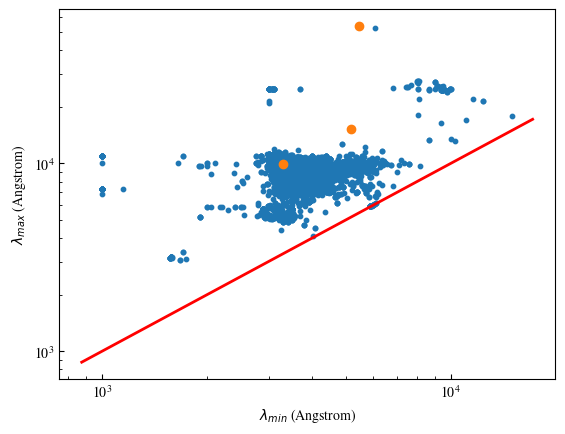

In [11]:
fig,ax =plt.subplots()
ax.scatter(spectra_data.lambda_data_min,spectra_data.lambda_data_max,s=10)

ax.set_yscale('log')
ax.set_xscale('log')
ax.scatter(spectra_data.loc[4236, 'lambda_data_min'], spectra_data.loc[4236, 'lambda_data_max'], c='C1')
ax.scatter(spectra_data.loc[21198, 'lambda_data_min'],spectra_data.loc[21198, 'lambda_data_max'], c='C1')
ax.scatter(spectra_data.loc[21334, 'lambda_data_min'], spectra_data.loc[21334, 'lambda_data_max'], c='C1')
ax.plot(ax.get_xlim(),ax.get_xlim(),color='red')
ax.set_xlabel(r'$\lambda_{min}$ (Angstrom)')
ax.set_ylabel(r'$\lambda_{max}$ (Angstrom)')
#ax.set_xlim(1e0,1e5)
plt.show()

[]

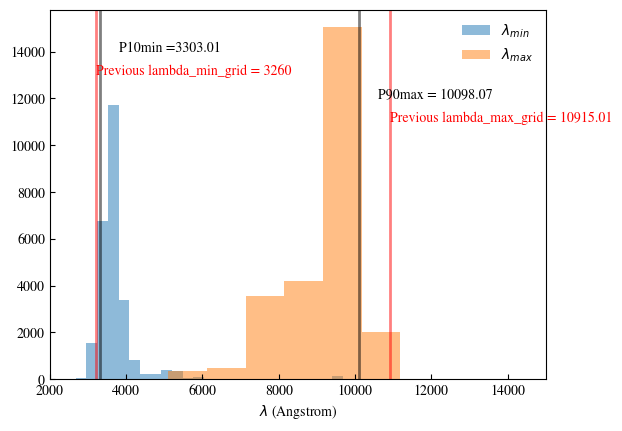

In [12]:
fig, ax = plt.subplots()

ax.hist(spectra_data.lambda_data_min, bins=50, alpha = 0.5, label=r'$\lambda_{min}$')
ax.hist(spectra_data.lambda_data_max, bins=50, alpha = 0.5, label=r'$\lambda_{max}$')
ax.axvline(spectra_data.lambda_data_min.quantile(0.1), color='black', alpha = 0.5,)
ax.axvline(spectra_data.lambda_data_max.quantile(0.9), color='black', alpha = 0.5,)
ax.axvline(3206.34, color='red', alpha = 0.5,)
ax.axvline(10915.01, color='red', alpha = 0.5,)
ax.text(x=3206, y = 13000, s=f'Previous lambda_min_grid = 3260', c='red')
ax.text(x=10915.01, y = 11000, s=f'Previous lambda_max_grid = 10915.01', c='red')
ax.text(x=spectra_data.lambda_data_min.quantile(0.1)+500, y = 14000, s=f'P10min ={spectra_data.lambda_data_min.quantile(0.1):.2f}')
ax.text(x=spectra_data.lambda_data_max.quantile(0.9)+500, y = 12000, s=f'P90max = {spectra_data.lambda_data_max.quantile(0.9):.2f}')
ax.set_xlabel(r'$\lambda$ (Angstrom)')

ax.set_xlim(2000,15000)
ax.legend(frameon=False)
plt.plot()

In [13]:
# Save the update data
# spectra_data.to_pickle('spectra_ALeRCE20240721_x_wisrep_20240622.pkl')

In [14]:
# Calculate the differences between the max and min wavelength to 
spectra_data['lambda_data_diff'] = spectra_data.lambda_data_max - spectra_data.lambda_data_min

In [15]:
spectra_data.sort_values(by='lambda_data_diff')[['snname','lambda_data_diff']][0:30]

,snname,lambda_data_diff
14887,SN2009mg,15.111256
9178,SN2007rw,21.395800
6716,SN2008cg,23.782200
6717,SN2008cg,24.387500
9533,SN2006cu,27.381700
11547,SNF20080514-002,28.701600
24430,SN2008J,30.415800
8276,SNF20080612-003,33.576300
9534,SN2006cu,33.604500
3779,SN2008dh,34.389200


[]

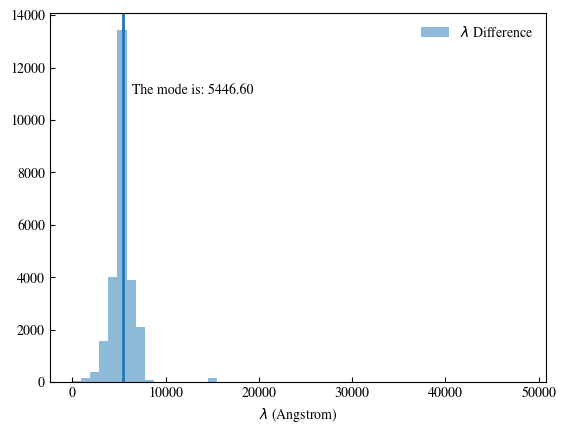

In [16]:

mode, _  = stats.mode(spectra_data.lambda_data_diff)

fig, ax = plt.subplots()

ax.hist(spectra_data.lambda_data_diff, bins=50, alpha = 0.5, label=r'$\lambda$ Difference')
ax.axvline(mode)
ax.text(mode+1000, 11000, f'The mode is: {mode:.2f}')
ax.set_xlabel(r'$\lambda$ (Angstrom)')

#ax.set_xlim(2000,15000)
ax.legend(frameon=False)
plt.plot()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[]

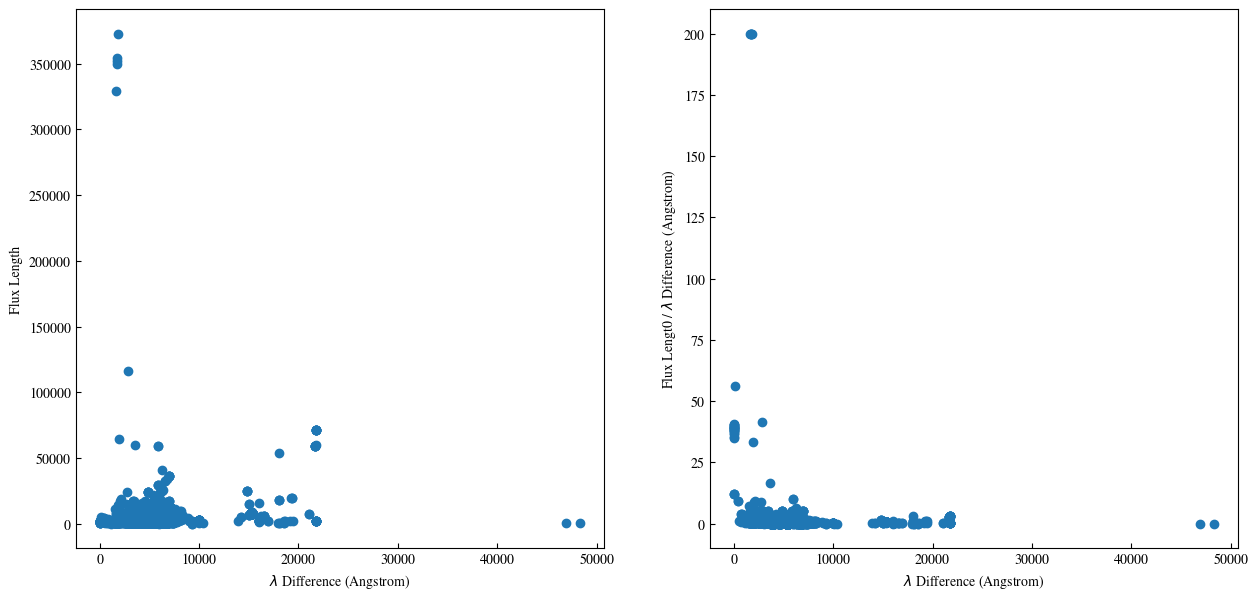

In [17]:
fig, (ax0,ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))

ax0.scatter(spectra_data.lambda_data_diff, spectra_data['flux_lambda'].apply(lambda x: len(x)))
ax0.set_xlabel(r'$\lambda$ Difference (Angstrom)')
ax0.set_ylabel(r'Flux Length')
#ax.set_xlim(2000,15000)
ax0.legend(frameon=False)

ax1.scatter(spectra_data.lambda_data_diff, spectra_data['flux_lambda'].apply(lambda x: len(x))/spectra_data.lambda_data_diff)
ax1.set_xlabel(r'$\lambda$ Difference (Angstrom)')
ax1.set_ylabel(r'Flux Lengt0 / $\lambda$ Difference (Angstrom)')
#ax.set_xlim(2000,15000)
ax1.legend(frameon=False)
plt.plot()

In [18]:
spectra_data[spectra_data['flux_lambda'].apply(lambda x: len(x))/spectra_data.lambda_data_diff > 150]['snname']

9374    SN1959D
9375    SN1959D
9376    SN1959D
9377    SN1959D
9389    SN1959D
Name: snname, dtype: object

In [19]:
noisy_spectra = spectra_data[spectra_data['flux_lambda'].apply(lambda x: len(x))/spectra_data.lambda_data_diff > 50]
noisy_spectra

,oid,snname,instrument,mjd,lambda_grid_min,lambda_grid_max,nlambda_grid,lambda_data_min,lambda_data_max,flux_lambda,e_flux_lambda,lambda_data_diff
8275,NaN,SNF20080612-003,Keck1_HIRES,54630.0,3206.34,10915.01,1838,4027.4608,4119.5738,"[0.9940684312328768, 0.9945475943243244, 0.996...","[0.006726308553339503, 0.00672240892510842, 0....",92.113
9374,NaN,SN1959D,Crossley_PNS,36750.0,3206.34,10915.01,1838,3541.0600,5288.3350,"[2.4636389198949793, 2.463679895119326, 2.4637...","[0.011273007317488527, 0.011272935719850614, 0...",1747.275
9375,NaN,SN1959D,Crossley_PNS,36751.0,3206.34,10915.01,1838,3510.7400,5156.2850,"[2.1424036524594974, 2.142182957042348, 2.1419...","[0.08908746829171327, 0.08907081319194879, 0.0...",1645.545
9376,NaN,SN1959D,Crossley_PNS,36753.0,3206.34,10915.01,1838,3511.6600,5284.8250,"[1.8241553869653255, 1.8241540749194258, 1.824...","[0.014430825276702754, 0.01443107396888482, 0....",1773.165
9377,NaN,SN1959D,Crossley_PNS,36754.0,3206.34,10915.01,1838,3522.5900,5283.5250,"[1.425216957863341, 1.4252561280282878, 1.4252...","[0.0069206400764422575, 0.006927560706207607, ...",1760.935
9389,NaN,SN1959D,Crossley_PNS,36811.0,3206.34,10915.01,1838,3421.6800,5285.7550,"[0.6076153532454839, 0.6075820860344816, 0.606...","[0.013312850294882331, 0.013310407793982081, 0...",1864.075


In [ ]:
# Lambda / Delta Lambda Resolution

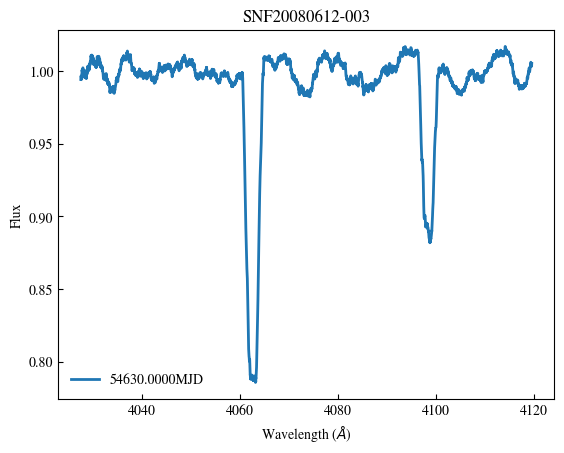

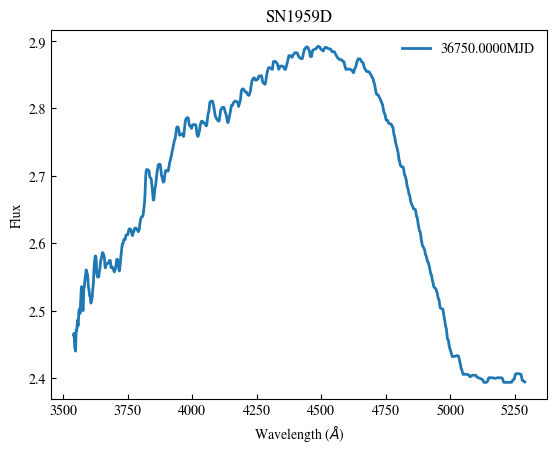

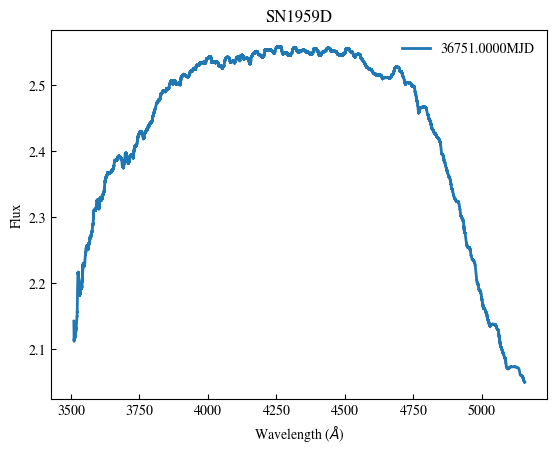

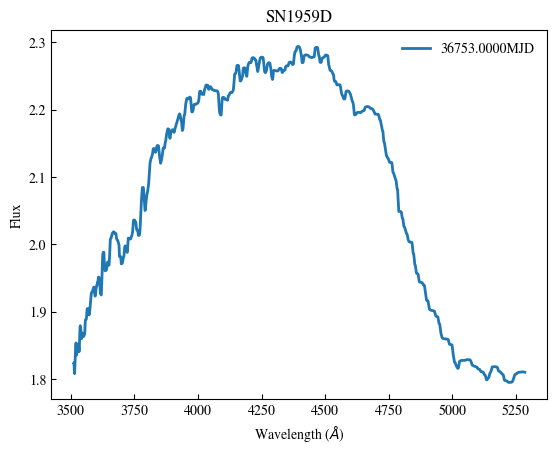

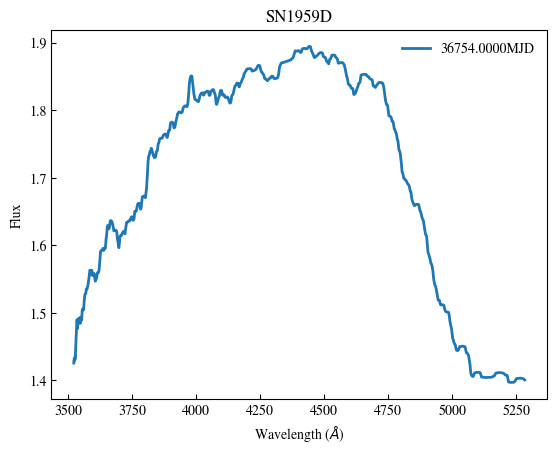

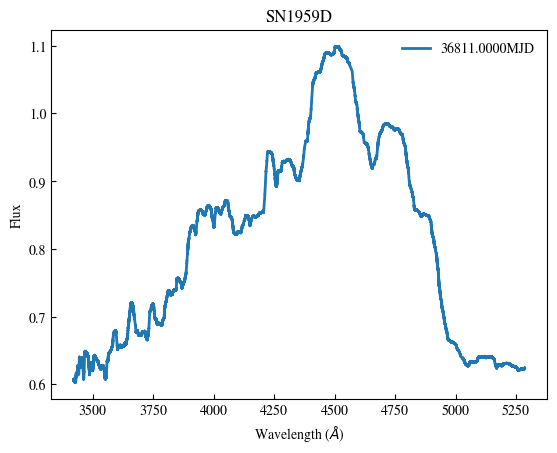

In [22]:
for _, spectrum in noisy_spectra.iterrows():
    plot_spectra(spectrum, use_lambda_grid=False, sn_name=spectrum.snname)

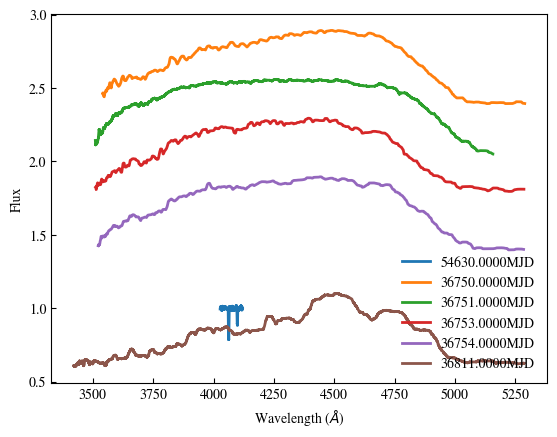

In [21]:
plot_spectra(noisy_spectra, use_lambda_grid=False)#, sn_name=sn_name)

In [ ]:
# Histograma por lambda

In [ ]:
lambda_data_min = np.array(spectra_data.lambda_data_min)

# This mask have the values less than 1000 Angstrom
mask_lambda_min_indx = np.where(lambda_data_min <= 2500)[0]
#print(len(np.where(lambda_data_min >= 10915.01)[0]))
#spectra_data.iloc[mask_lambda_min_indx[1]].lambda_data_min
lambda_data_min.max()

In [ ]:
mask = np.ones(len(spectra_data), dtype=bool)
mask[mask_lambda_min_indx] = False
masked_spectra_data = spectra_data.iloc[mask].reset_index(drop=True)
masked_spectra_data = masked_spectra_data[masked_spectra_data.lambda_data_min <= 5000]

In [ ]:
from sklearn.preprocessing import StandardScaler

# Calcular los valores de la función gaussiana
x = np.linspace(masked_spectra_data.lambda_data_min.min(), masked_spectra_data.lambda_data_min.max(), 1000)
mu, sigma = masked_spectra_data.lambda_data_min.mean(), masked_spectra_data.lambda_data_min.std()

def gaussian(x, mu, sig):
    return 1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2)

# Crear la figura de matplotlib
fig, ax = plt.subplots()

# Graficar el histograma de los datos originales con densidad normalizada
n, bins, patches = ax.hist(masked_spectra_data.lambda_data_min, bins=30, density=True, alpha=0.5, color='g')

# Normalizar el histograma
bin_centers = 0.5 * (bins[1:] + bins[:-1])
scale_factor = np.sum(n * np.diff(bins))
n_normalized = n / scale_factor

# Graficar la curva gaussiana normalizada
ax.plot(x, gaussian(x, mu, sigma) / scale_factor, 'r', linewidth=2)

# Etiquetas y título
#ax.set_ylabel("Densidad Normalizada")
ax.set_xlabel(r"Wavelength [$\AA$]")
#ax.set_title("Histograma y Curva Gaussiana Normalizados")

# Añadir el texto con mu y sigma
ax.text(0.05, 0.8, s='N = %d spectra'%(len(masked_spectra_data.lambda_data_min)) \
        +'\n'+r'$\mu$ = %.2f, $\sigma$ = %.2f' %(mu, sigma), transform=ax.transAxes)

# Mostrar la gráfica
plt.show()

In [ ]:
spectra_data_oid_non_nan = spectra_data.dropna()
condition = spectra_data_oid_non_nan.pivot_table(index='oid', aggfunc='size') >= 4
test = spectra_data_oid_non_nan[spectra_data_oid_non_nan.oid.isin(condition[condition].index)]
test[130:140]